# Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind NMF implementation, training examples and use-cases.

**Matrix Factorizations** are useful for many things: recomendation systems, bi-clustering, image compression and, in particular, topic modeling.

Why **Non-Negative**? It makes the problem more strict and allows us to apply some optimizations.

Why **Online**? Because corpora are large and RAM is limited. Online NMF can learn topics iteratively.

This particular implementation is based on [this paper](arxiv.org/abs/1604.02634).

## Preprocessing

In [61]:
%load_ext autoreload
%load_ext line_profiler

%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader as api
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset preprocessing

In [3]:
newsgroups = api.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {
    name: idx
    for idx, name
    in enumerate(categories)
}

In [4]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc
    in newsgroups
    if doc['topic'] in categories
    and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc
    in newsgroups
    if doc['topic'] in categories
    and doc['set'] == 'test'
])
random_state.shuffle(testset)

In [5]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

In [6]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes()

2019-01-29 02:37:27,124 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-01-29 02:37:27,709 : INFO : built Dictionary(25279 unique tokens: ['actual', 'assum', 'babbl', 'batka', 'batkaj']...) from 2819 documents (total 435328 corpus positions)
2019-01-29 02:37:27,753 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-01-29 02:37:27,754 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-01-29 02:37:27,766 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['actual', 'assum', 'babbl', 'burster', 'caus']...)


### Corpora compilation

In [7]:
train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

## Training

The API works in the way similar to [Gensim.models.LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html).

Specific parameters:

- `use_r` - whether to use residuals. Effectively adds regularization to the model
- `kappa` - optimizer step size coefficient.
- `lambda_` - residuals coefficient. The larger it is, the less more regularized result gets.
- `sparse_coef` - internal matrices sparse coefficient. The more it is, the faster and less accurate training is.

In [85]:
%%time

nmf = GensimNmf(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
    use_r=False,
    lambda_=1000,
    kappa=1,
)

2019-01-29 04:12:00,476 : INFO : Loss (no outliers): 5.469144952747101	Loss (with outliers): 5.469144952747101
2019-01-29 04:12:00,667 : INFO : Loss (no outliers): 5.653626155222666	Loss (with outliers): 5.653626155222666


CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 635 ms


### Topics

In [86]:
nmf.show_topics()

[(0,
  '0.017*"armenian" + 0.015*"peopl" + 0.014*"said" + 0.013*"know" + 0.008*"went" + 0.008*"sai" + 0.007*"like" + 0.007*"apart" + 0.007*"come" + 0.007*"azerbaijani"'),
 (1,
  '0.074*"jpeg" + 0.032*"file" + 0.031*"gif" + 0.028*"imag" + 0.024*"color" + 0.017*"format" + 0.014*"qualiti" + 0.013*"convert" + 0.013*"compress" + 0.013*"version"'),
 (2,
  '0.030*"imag" + 0.014*"graphic" + 0.012*"data" + 0.010*"file" + 0.010*"pub" + 0.010*"ftp" + 0.010*"avail" + 0.008*"format" + 0.008*"program" + 0.008*"packag"'),
 (3,
  '0.015*"god" + 0.012*"atheist" + 0.009*"believ" + 0.009*"exist" + 0.008*"atheism" + 0.007*"peopl" + 0.007*"religion" + 0.006*"christian" + 0.006*"israel" + 0.006*"religi"'),
 (4,
  '0.028*"space" + 0.019*"launch" + 0.013*"satellit" + 0.009*"orbit" + 0.008*"nasa" + 0.007*"year" + 0.006*"mission" + 0.006*"new" + 0.006*"commerci" + 0.005*"market"')]

### Coherence

In [87]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus,
    coherence='u_mass'
).get_coherence()

2019-01-29 04:12:06,256 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-1.7025419296549071

### Perplexity

In [88]:
np.exp(-nmf.log_perplexity(test_corpus))

2497.309763793742

### Document topics inference

In [89]:
print(testset[0]['data'])
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.28750486088175325)

### Word topic inference

In [90]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.048754678494518006), (1, 0.13104836293919045), (2, 0.07901382730995936), (3, 0.6537466789121008), (4, 0.0874364523442313)]


### Internal state

In [91]:
def density(sparse_matrix):
    return sparse_matrix.nnz / np.multiply(*sparse_matrix.shape)

Term-topic matrix of shape `(words, topics)`.

In [92]:
import scipy.sparse as sparse

In [93]:
sparse.csc_matrix(nmf._W)

<7081x5 sparse matrix of type '<class 'numpy.float64'>'
	with 22718 stored elements in Compressed Sparse Column format>

In [94]:
print("Density: {}".format(density(sparse.csc_matrix(nmf._W))))

Density: 0.6416607823753707


Topic-document matrix for the last batch of shape `(topics, batch)`

In [95]:
sparse.csc_matrix(nmf._h)

<5x819 sparse matrix of type '<class 'numpy.float64'>'
	with 3445 stored elements in Compressed Sparse Column format>

In [96]:
print("Density: {}".format(density(sparse.csc_matrix(nmf._h))))

Density: 0.8412698412698413


Residuals matrix of the last batch of shape `(words, batch)`

In [97]:
nmf._r

<7081x819 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

In [98]:
print("Density: {}".format(density(nmf._r)))

Density: 0.0


# Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

In [121]:
variable_params_grid = list(ParameterGrid(dict(
    use_r=[False, True],
    lambda_=[1, 10, 100]
)))

fixed_params = dict(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

In [122]:
def get_execution_time(func):
    start = time.time()

    result = func()

    return (time.time() - start), result


def get_tm_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = np.zeros((len(train_corpus), model.num_topics))
    for bow_id, bow in enumerate(train_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            X_train[bow_id, topic_id] = factor

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_sklearn_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = model.transform((train_corpus / train_corpus.sum(axis=0)).T)

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_tm_metrics(model, train_corpus, test_corpus, dense_corpus, y_train, y_test):
    W = model.get_topics().T
    H = np.zeros((model.num_topics, len(test_corpus)))
    for bow_id, bow in enumerate(test_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            H[topic_id, bow_id] = factor

    pred_factors = W.dot(H)
    pred_factors /= pred_factors.sum(axis=0)

    perplexity = get_tm_perplexity(pred_factors, dense_corpus)

    l2_norm = get_tm_l2_norm(pred_factors, dense_corpus)

    f1 = get_tm_f1(model, train_corpus, H.T, y_train, y_test)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()

    topics = model.show_topics()

    model.normalize = False

    return dict(
        perplexity=perplexity,
        coherence=coherence,
        topics=topics,
        l2_norm=l2_norm,
        f1=f1,
    )


def get_tm_perplexity(pred_factors, dense_corpus):
    return np.exp(-(np.log(pred_factors, where=pred_factors > 0) * dense_corpus).sum() / dense_corpus.sum())


def get_tm_l2_norm(pred_factors, dense_corpus):
    return np.linalg.norm(dense_corpus / dense_corpus.sum(axis=0) - pred_factors)


def get_sklearn_metrics(model, train_corpus, test_corpus, y_train, y_test):
    W = model.components_.T
    H = model.transform((test_corpus / test_corpus.sum(axis=0)).T).T
    pred_factors = W.dot(H)
    pred_factors /= pred_factors.sum(axis=0)

    perplexity = np.exp(
        -(np.log(pred_factors, where=pred_factors > 0) * test_corpus).sum()
        / test_corpus.sum()
    )

    l2_norm = np.linalg.norm(test_corpus / test_corpus.sum(axis=0) - pred_factors)

    f1 = get_sklearn_f1(model, train_corpus, H.T, y_train, y_test)

    return dict(
        perplexity=perplexity,
        l2_norm=l2_norm,
        f1=f1,
    )

In [ ]:
tm_metrics = pd.DataFrame()

train_dense_corpus = matutils.corpus2dense(train_corpus, len(dictionary))
test_dense_corpus = matutils.corpus2dense(test_corpus, len(dictionary))

trainset_target = [doc['target'] for doc in trainset]
testset_target = [doc['target'] for doc in testset]

# LDA metrics
row = dict()
row['model'] = 'lda'
row['train_time'], lda = get_execution_time(
    lambda: LdaModel(**fixed_params)
)
row.update(get_tm_metrics(
    lda, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = dict()
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)
row['train_time'], sklearn_nmf = get_execution_time(
    lambda: sklearn_nmf.fit((train_dense_corpus / train_dense_corpus.sum(axis=0)).T)
)
row.update(get_sklearn_metrics(
    sklearn_nmf, train_dense_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

for variable_params in variable_params_grid:
    row = dict()
    row['model'] = 'gensim_nmf'
    row.update(variable_params)
    row['train_time'], model = get_execution_time(
        lambda: GensimNmf(
            normalize=False,
            **fixed_params,
            **variable_params,
        )
    )
    row.update(get_tm_metrics(
        model, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
    ))
    tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-01-29 04:53:29,057 : INFO : using symmetric alpha at 0.2
2019-01-29 04:53:29,058 : INFO : using symmetric eta at 0.2
2019-01-29 04:53:29,060 : INFO : using serial LDA version on this node
2019-01-29 04:53:29,085 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-01-29 04:53:29,089 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-01-29 04:53:30,071 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-01-29 04:53:30,078 : INFO : topic #0 (0.200): 0.006*"com" + 0.005*"new" + 0.005*"peopl" + 0.004*"space" + 0.004*"like" + 0.004*"univers" + 0.004*"time" + 0.004*"nntp" + 0.004*"armenian" + 0.004*"host"
2019-01-29 04:53:30,079 : INFO : topic #1 (0.200): 0.007*"com" + 0.005*"like" + 0.005*"peopl" + 0.005*"know" + 0.004*"think" + 0.004*"time" + 0.004*

2019-01-29 04:53:36,671 : INFO : topic diff=0.423403, rho=0.455535
2019-01-29 04:53:36,672 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-01-29 04:53:37,492 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-01-29 04:53:37,504 : INFO : topic #0 (0.200): 0.009*"space" + 0.007*"com" + 0.006*"bike" + 0.006*"new" + 0.005*"univers" + 0.005*"orbit" + 0.004*"nasa" + 0.004*"year" + 0.004*"like" + 0.004*"time"
2019-01-29 04:53:37,505 : INFO : topic #1 (0.200): 0.010*"com" + 0.009*"god" + 0.007*"peopl" + 0.007*"like" + 0.007*"think" + 0.006*"know" + 0.006*"thing" + 0.006*"moral" + 0.005*"time" + 0.005*"atheist"
2019-01-29 04:53:37,506 : INFO : topic #2 (0.200): 0.012*"israel" + 0.010*"isra" + 0.007*"jew" + 0.007*"peopl" + 0.006*"arab" + 0.006*"islam" + 0.005*"right" + 0.005*"think" + 0.005*"state" + 0.004*"univers"
2019-01-29 04:53:37,508 : INFO : topic #3 (0.200): 0.013*"imag" + 0.009*"file" + 0.009*"graphic" + 0.009*"com" + 0.007*"program" + 0.006*"us" + 0

2019-01-29 04:53:43,594 : INFO : topic #1 (0.200): 0.011*"com" + 0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.007*"like" + 0.006*"thing" + 0.006*"know" + 0.006*"moral" + 0.005*"atheist" + 0.005*"time"
2019-01-29 04:53:43,595 : INFO : topic #2 (0.200): 0.013*"israel" + 0.011*"isra" + 0.009*"jew" + 0.007*"arab" + 0.007*"peopl" + 0.006*"islam" + 0.006*"right" + 0.005*"state" + 0.005*"think" + 0.004*"peac"
2019-01-29 04:53:43,597 : INFO : topic #3 (0.200): 0.014*"imag" + 0.010*"file" + 0.010*"graphic" + 0.008*"com" + 0.008*"program" + 0.006*"us" + 0.006*"univers" + 0.005*"softwar" + 0.005*"host" + 0.005*"jpeg"
2019-01-29 04:53:43,598 : INFO : topic #4 (0.200): 0.019*"armenian" + 0.011*"turkish" + 0.010*"peopl" + 0.006*"said" + 0.006*"armenia" + 0.006*"turk" + 0.005*"turkei" + 0.005*"know" + 0.004*"greek" + 0.004*"year"
2019-01-29 04:53:43,599 : INFO : topic diff=0.204473, rho=0.357622
2019-01-29 04:53:43,600 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-01-29 04:53:44,240 : INF

## Result table

In [102]:
tm_metrics.sort_values('f1')

,coherence,f1,l2_norm,model,perplexity,topics,train_time,lambda_,sparse_coef,use_r
1,NaN,0.696695,6.929583,sklearn_nmf,2404.189918,NaN,13.062899,NaN,NaN,NaN
2,-1.702542,0.711087,7.060992,gensim_nmf,2473.714343,"[(0, 0.017*""armenian"" + 0.015*""peopl"" + 0.014*...",0.743854,1.0,0.0,0.0
3,-1.702542,0.711087,7.060992,gensim_nmf,2473.714343,"[(0, 0.017*""armenian"" + 0.015*""peopl"" + 0.014*...",0.786501,1.0,3.0,0.0
0,-1.755650,0.765458,7.002725,lda,1939.575705,"[(0, 0.014*""space"" + 0.008*""com"" + 0.007*""bike...",15.605637,NaN,NaN,NaN


In [103]:
print("Best NMF's topics")
tm_metrics.iloc[3].topics

Best NMF's topics


[(0,
  '0.017*"armenian" + 0.015*"peopl" + 0.014*"said" + 0.013*"know" + 0.008*"went" + 0.008*"sai" + 0.007*"like" + 0.007*"apart" + 0.007*"come" + 0.007*"azerbaijani"'),
 (1,
  '0.074*"jpeg" + 0.032*"file" + 0.031*"gif" + 0.028*"imag" + 0.024*"color" + 0.017*"format" + 0.014*"qualiti" + 0.013*"convert" + 0.013*"compress" + 0.013*"version"'),
 (2,
  '0.030*"imag" + 0.014*"graphic" + 0.012*"data" + 0.010*"file" + 0.010*"pub" + 0.010*"ftp" + 0.010*"avail" + 0.008*"format" + 0.008*"program" + 0.008*"packag"'),
 (3,
  '0.015*"god" + 0.012*"atheist" + 0.009*"believ" + 0.009*"exist" + 0.008*"atheism" + 0.007*"peopl" + 0.007*"religion" + 0.006*"christian" + 0.006*"israel" + 0.006*"religi"'),
 (4,
  '0.028*"space" + 0.019*"launch" + 0.013*"satellit" + 0.009*"orbit" + 0.008*"nasa" + 0.007*"year" + 0.006*"mission" + 0.006*"new" + 0.006*"commerci" + 0.005*"market"')]

In [104]:
print('LDA topics')
tm_metrics.iloc[0].topics

LDA topics


[(0,
  '0.014*"space" + 0.008*"com" + 0.007*"bike" + 0.007*"nasa" + 0.005*"new" + 0.005*"orbit" + 0.005*"launch" + 0.005*"year" + 0.005*"univers" + 0.004*"like"'),
 (1,
  '0.011*"god" + 0.011*"com" + 0.008*"peopl" + 0.008*"think" + 0.007*"like" + 0.006*"thing" + 0.006*"know" + 0.005*"moral" + 0.005*"believ" + 0.005*"time"'),
 (2,
  '0.013*"israel" + 0.011*"isra" + 0.010*"jew" + 0.007*"arab" + 0.007*"peopl" + 0.006*"state" + 0.006*"islam" + 0.006*"right" + 0.005*"think" + 0.004*"jewish"'),
 (3,
  '0.012*"imag" + 0.010*"graphic" + 0.010*"file" + 0.008*"com" + 0.008*"program" + 0.006*"softwar" + 0.006*"univers" + 0.006*"us" + 0.005*"mail" + 0.005*"host"'),
 (4,
  '0.020*"armenian" + 0.012*"turkish" + 0.010*"peopl" + 0.007*"said" + 0.006*"turkei" + 0.006*"armenia" + 0.006*"turk" + 0.005*"know" + 0.004*"greek" + 0.004*"year"')]

- Gensim NMF clearly beats sklearn implementation both in terms of speed and quality
- LDA is still significantly better in terms of quality, though interpretabiliy of topics and speed are clearly worse then NMF's

## Olivietti faces + Gensim NMF
NMF algorithm works not only with texts, but with all kinds of stuff!

Let's run our model with other factorization algorithms and check out the results

### Sklearn wrapper
We need that wrapper to compare Gensim NMF with other factorizations on images

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = matutils.Dense2Corpus(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.152s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.903s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2019-01-29 04:20:57,939 : INFO : Loss (no outliers): 0.4504334085008111	Loss (with outliers): 0.4504334085008111
2019-01-29 04:20:57,941 : INFO : Loss (no outliers): 0.4504334085008111	Loss (with outliers): 0.4504334085008111


done in 2.288s
Extracting the top 6 Independent components - FastICA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


done in 0.451s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.194s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.515s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.208s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.355s


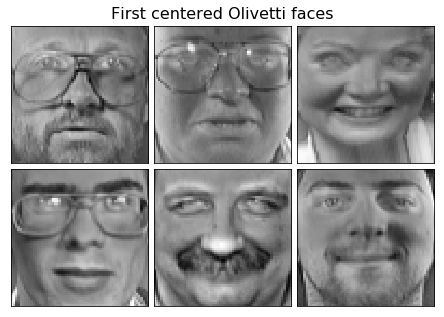

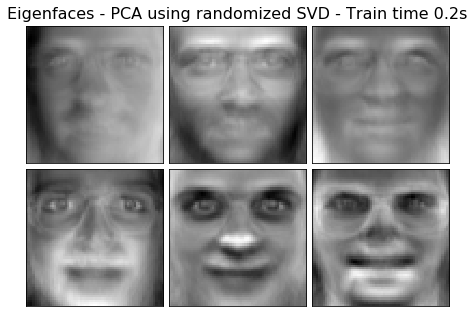

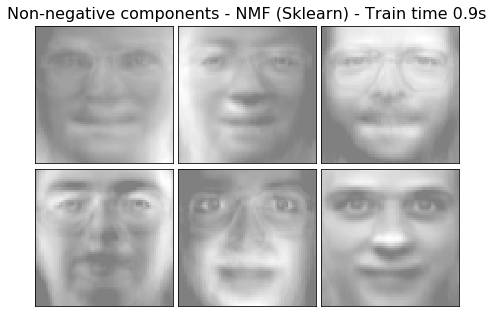

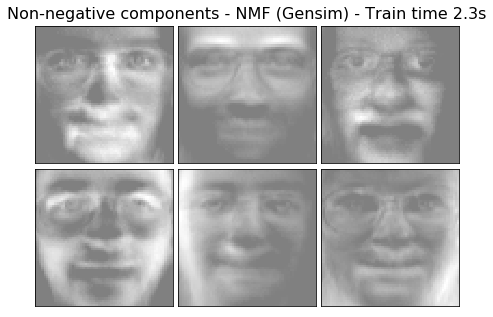

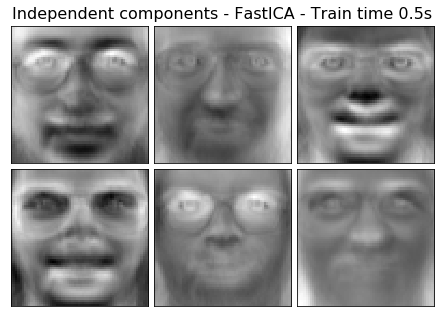

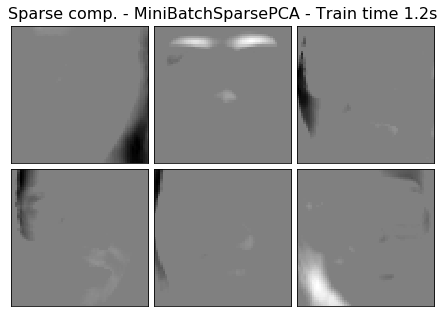

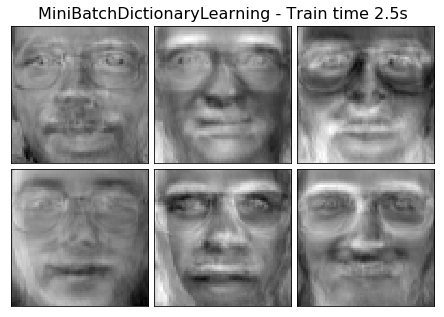

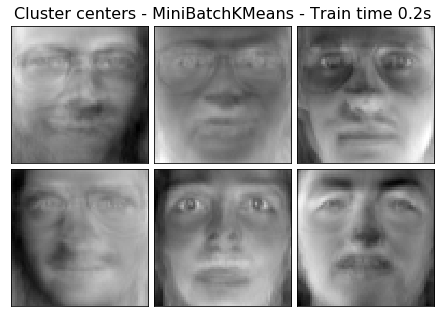

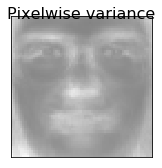

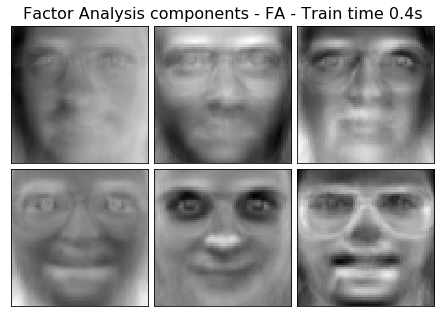

In [115]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=1,
         eval_every=400,
         passes=1,
         use_r=
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

Let's profile the main loop of the model:

In [120]:
%lprun -f GensimNmf.update estimators[2][1].fit(faces)

2019-01-29 04:31:26,769 : INFO : Loss (no outliers): 0.05749070150693296	Loss (with outliers): 0.05749070150693296
2019-01-29 04:31:26,771 : INFO : Loss (no outliers): 0.05749070150693296	Loss (with outliers): 0.05749070150693296


```
   482         2          6.0      3.0      0.0          for _ in range(self.passes):
   483         1          3.0      3.0      0.0              for chunk in utils.grouper(
   484       401     451654.0   1126.3     12.7                  corpus, self.chunksize, as_numpy=chunks_as_numpy
   485                                                       ):
   486       400       4438.0     11.1      0.1                  self.random_state.shuffle(chunk)
   487       400    1521337.0   3803.3     42.8                  v = matutils.corpus2csc(chunk, len(self.id2word))
   488       400       1159.0      2.9      0.0                  self._h, self._r = self._solveproj(
   489       400     878565.0   2196.4     24.7                      v, self._W, r=self._r, h=self._h, v_max=self.v_max
   490                                                           )
   491       400        960.0      2.4      0.0                  h, r = self._h, self._r
```

As you can see, the main difference in time between sklearn's NMF implementation and ours comes from the corpus conversion to the csc matrix, which is not the optimal matrix format in this particular case.